## Notebook Régression 

In [11]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn.preprocessing 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.regression.linear_model import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import operator
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeRegressor 

## Importation des BDD

In [4]:
## Chargement des données énédis
#chemin jérémie
#enedis_final = pd.read_csv("/Users/jeremiedarracq/Stat-app/enedis_final.csv",sep=",")
#enedis_final = pd.read_csv("/Users/jeremiedarracq/Stat-app/enedis_final_3h.csv",sep=",")

#chemin elena
enedis_final = pd.read_csv("Données/enedis_final.csv",sep=",")

#chemin côme
#enedis = pd.read_csv("/Users/",sep=";")


In [5]:
## Chargement des données méteo + modification du noms des régions
#meteo_reg_df=pd.read_csv("/Users/jeremiedarracq/Stat-app/temperature_reg.csv",";")
meteo_reg_df=pd.read_csv("Données/temperature-quotidienne-regionale.csv",";")


## Récuperer toutes les régions de la BDD puis modification des noms
regions=meteo_reg_df["region"].unique()
regions=list(regions)

meteo_reg_df.loc[meteo_reg_df["region"]=="Nouvelle-Aquitaine","region"] = "Nouvelle Aquitaine"
meteo_reg_df.loc[meteo_reg_df["region"]=="Grand Est","region"] = "Grand-Est"


c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


### Pré-processing

In [12]:
def pre_processing(bdd,region): ## rajouter meteo_reg si changement de bbdd
    enedis_region= bdd.loc[bdd.region_x == region]
    enedis_region_new = enedis_region.groupby("horodate")["total_energie_soutiree_wh"].sum().reset_index()
    #enedis_meteo_new = enedis_region.groupby("horodate")["Température (°C)_x"].mean().reset_index()
    #enedis_meteo_new["tmoy"] = enedis_meteo_new["Température (°C)_x"]
    enedis_region_new["date"]= enedis_region_new["horodate"].apply(lambda x : x[0:10])
    meteo_reg_region= meteo_reg_df[meteo_reg_df.region==region]
    enedis_prev_region = enedis_region_new.groupby("date")["total_energie_soutiree_wh"].sum().reset_index()
    enedis_prev_cleen = enedis_prev_region.merge(meteo_reg_region,on="date")

    #standardisation des données
    enedis_prev_cleen["tmoy_scaled"]=scale(enedis_prev_cleen["tmoy"])

    return enedis_prev_cleen

#pd.merge(enedis,socio,how='left',left_on="code_region",right_on="Code")

In [13]:
enedis_IDF = pre_processing(enedis_final,"Île-de-France")
enedis_HDF = pre_processing(enedis_final,"Hauts-de-France")
enedis_PACA = pre_processing(enedis_final,"Provence-Alpes-Côte d'Azur")
enedis_CVL = pre_processing(enedis_final,"Centre-Val de Loire")
enedis_Normandie = pre_processing(enedis_final,"Normandie")
enedis_Occitanie = pre_processing(enedis_final,"Occitanie")
enedis_ARA = pre_processing(enedis_final,"Auvergne-Rhône-Alpes")
enedis_BFC= pre_processing(enedis_final,"Bourgogne-Franche-Comté")
enedis_NA = pre_processing(enedis_final,"Nouvelle Aquitaine")
enedis_Bretagne = pre_processing(enedis_final,"Bretagne")
enedis_GE = pre_processing(enedis_final,"Grand-Est")
enedis_PDL = pre_processing(enedis_final,"Pays de la Loire")


In [15]:
enedis_IDF.to_csv("Données/donnees_r/enedis_IDF.csv",index=False)
enedis_HDF.to_csv("Données/donnees_r/enedis_HDF.csv",index=False)
enedis_PACA.to_csv("Données/donnees_r/enedis_PACA.csv",index=False)
enedis_CVL.to_csv("Données/donnees_r/enedis_CVL.csv",index=False)
enedis_Normandie.to_csv("Données/donnees_r/enedis_Normandie.csv",index=False)
enedis_Occitanie.to_csv("Données/donnees_r/enedis_Occitanie.csv",index=False)
enedis_ARA.to_csv("Données/donnees_r/enedis_ARA.csv",index=False)
enedis_BFC.to_csv("Données/donnees_r/enedis_BFC.csv",index=False)
enedis_NA.to_csv("Données/donnees_r/enedis_NA.csv",index=False)
enedis_Bretagne.to_csv("Données/donnees_r/enedis_Bretagne.csv",index=False)
enedis_GE.to_csv("Données/donnees_r/enedis_GE.csv",index=False)
enedis_PDL.to_csv("Données/donnees_r/enedis_PDL.csv",index=False)

## I - Régression linéaire simple 
Objectif : Prédiction du Total d'énergie soutirée par journée en fonction de la température de la journée sur une région particulière 

Méthode : 
- On somme le total d'énergie soutirée par 1/2h sur 3heure en agrégant tout les points de soutirages 
- On l'associe avec la température sur la journée 
- Réalisation d'une régression simple 

In [16]:
def decoupe (bdd_region):
    X=bdd_region[["tmoy_scaled"]]
    Y=bdd_region[["total_energie_soutiree_wh"]]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
    return (X,Y, X_train, X_test, Y_train, Y_test )

In [17]:
## Création des échantillons d'apprentissages et de tests

X_ARA,Y_ARA , X_train_ARA, X_test_ARA, Y_train_ARA, Y_test_ARA =decoupe(enedis_ARA)
X_IDF,Y_IDF , X_train_IDF, X_test_IDF, Y_train_IDF, Y_test_IDF =decoupe(enedis_IDF)
X_PACA,Y_PACA , X_train_PACA, X_test_PACA, Y_train_PACA, Y_test_PACA =decoupe(enedis_PACA)
X_HDF,Y_HDF , X_train_HDF, X_test_HDF, Y_train_HDF, Y_test_HDF =decoupe(enedis_HDF)
X_NA,Y_NA , X_train_NA, X_test_NA, Y_train_NA, Y_test_NA =decoupe(enedis_NA)
X_GE,Y_GE , X_train_GE, X_test_GE, Y_train_GE, Y_test_GE =decoupe(enedis_GE)
X_Bretagne,Y_Bretagne , X_train_Bretagne, X_test_Bretagne, Y_train_Bretagne, Y_test_Bretagne =decoupe(enedis_Bretagne)
X_CVL,Y_ICVL, X_train_CVL, X_test_CVL, Y_train_CVL, Y_test_CVL =decoupe(enedis_CVL)
X_BFC,Y_BFC , X_train_BFC, X_test_BFC, Y_train_BFC, Y_test_BFC =decoupe(enedis_BFC)
X_Occitanie,Y_Occitanie , X_train_Occitanie, X_test_Occitanie, Y_train_Occitanie, Y_test_Occitanie =decoupe(enedis_Occitanie)
X_Normandie,Y_Normandie , X_train_Normandie, X_test_Normandie, Y_train_Normandie, Y_test_Normandie =decoupe(enedis_Normandie)
X_PDL,Y_PDL , X_train_PDL, X_test_PDL, Y_train_PDL, Y_test_PDL =decoupe(enedis_PDL)


### Regression sur l'échantillon d'apprentissage 

Partie Résultats statistiques

In [20]:
## Création de la fonction de régression utilisant statmodel ( meilleur pour la visualisation des résultats statistique)
def reg_sm(X_train,Y_train):
    X_train_sm = sm.add_constant(X_train)
    model = sm.OLS(Y_train,X_train_sm).fit()
    print_model = model.summary()
    return print_model,model.rsquared,model.params.tmoy_scaled,model.conf_int(alpha=0.05,cols=None).loc["tmoy_scaled"].reset_index().T.iloc[1:]

In [21]:
## Stockage des résultats des régressions pour chaque régions 
res_reg_IDF,R2_IDF,coeff_reg_IDF,conf_int_IDF = reg_sm(X_train_IDF,Y_train_IDF)
res_reg_PACA,R2_PACA,coeff_reg_PACA,conf_int_PACA = reg_sm(X_train_PACA,Y_train_PACA)
res_reg_ARA,R2_ARA,coeff_reg_ARA,conf_int_ARA = reg_sm(X_train_ARA,Y_train_ARA)
res_reg_HDF,R2_HDF,coeff_reg_HDF,conf_int_HDF = reg_sm(X_train_HDF,Y_train_HDF)
res_reg_PDL,R2_PDL,coeff_reg_PDL,conf_int_PDL = reg_sm(X_train_PDL,Y_train_PDL)
res_reg_Normandie,R2_Normandie, coeff_reg_Normandie,conf_int_Normandie = reg_sm(X_train_Normandie,Y_train_Normandie)
res_reg_Occitanie,R2_Occitanie,coeff_reg_Occitanie,conf_int_Occitanie = reg_sm(X_train_Occitanie,Y_train_Occitanie)
res_reg_Bretagne,R2_Bretagne,coeff_reg_Bretagne,conf_int_Bretagne = reg_sm(X_train_Bretagne,Y_train_Bretagne)
res_reg_NA,R2_NA,coeff_reg_NA,conf_int_NA= reg_sm(X_train_NA,Y_train_NA)
res_reg_GE,R2_GE,coeff_reg_GE,conf_int_GE = reg_sm(X_train_GE,Y_train_GE)
res_reg_BFC,R2_BFC,coeff_reg_BFC,conf_int_BFC = reg_sm(X_train_BFC,Y_train_BFC)
res_reg_CVL , R2_CVL,coeff_reg_CVL,conf_int_CVL= reg_sm(X_train_CVL,Y_train_CVL)

Partie visualisation 

In [27]:
## Création de la fonction qui visualise la régression sur l'échantillon d'apprentissage 
def linear_plot(feature, label,region):
  # Create 1D array. We can use 'squeeze' function to reduce the 2D array to 1D array
  x_coordinates = np.squeeze(feature)
  y_coordinates = np.squeeze(label)
 # Contruct first degree polynomial function
  linear_func = np.poly1d(np.polyfit(x_coordinates, y_coordinates, 1))
  # Generate evenly spaced values
  values = np.linspace(x_coordinates.min(), x_coordinates.max(), len(x_coordinates))
  plt.scatter(x_coordinates,y_coordinates, color='blue')  
  #plt.plot(values, linear_func(values), color='red', label='Fonction linéaire')
  plt.plot(values, linear_func(values), color='red', label='Fonction linéaire')
  plt.xlabel('température moyenne standardisée ')
  plt.ylabel('Total énergie soutirée (wh) ')
  plt.rcParams["figure.figsize"] = (10,6) # Custom figure size in inches
  plt.legend()
  plt.title("Fonction linéaire sur base d'apprentissage pour la région "+region)
  plt.show()  

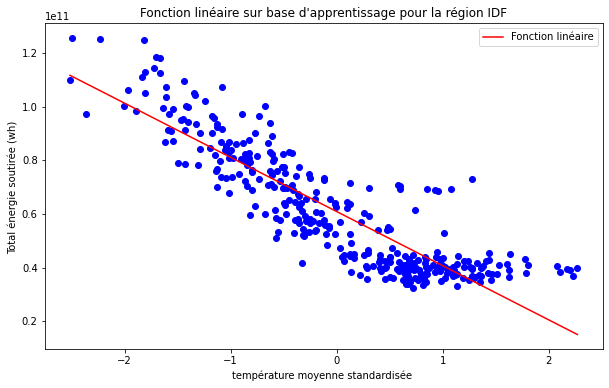

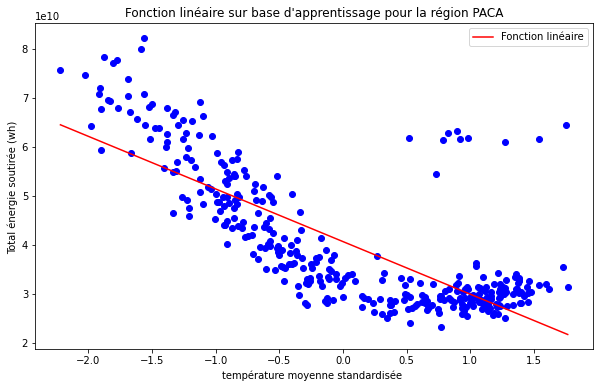

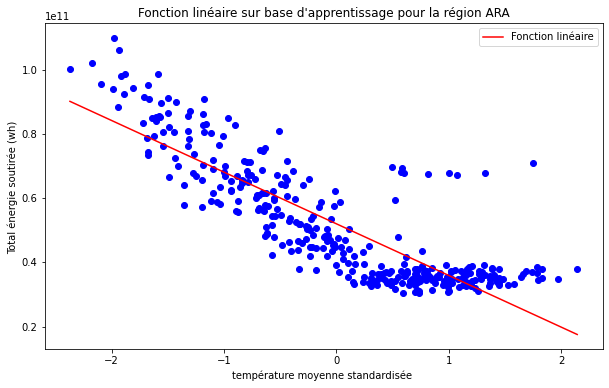

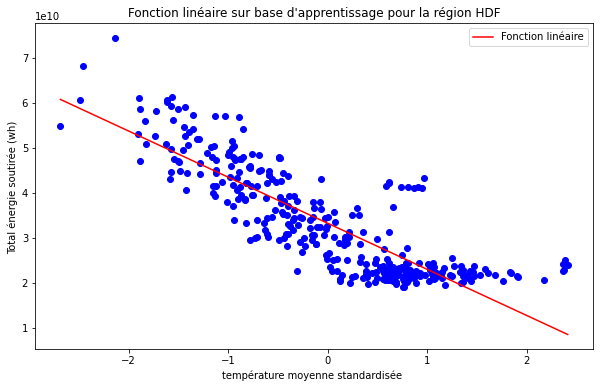

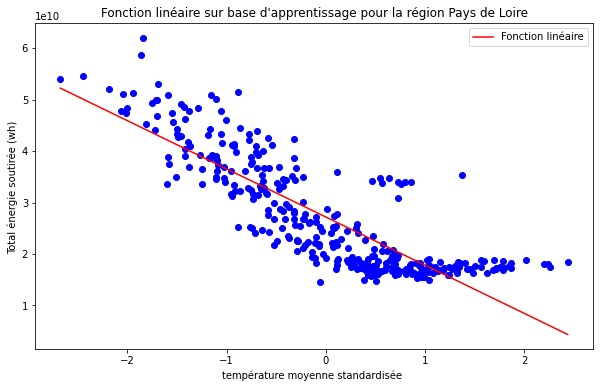

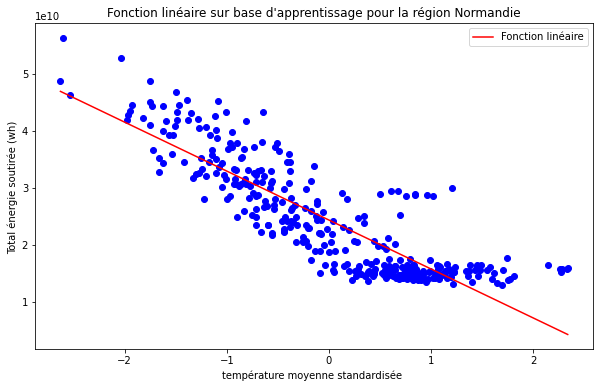

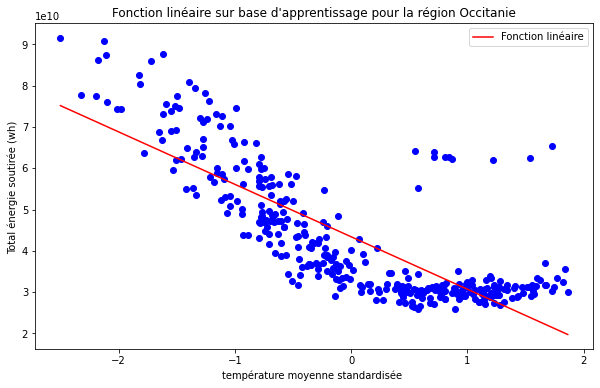

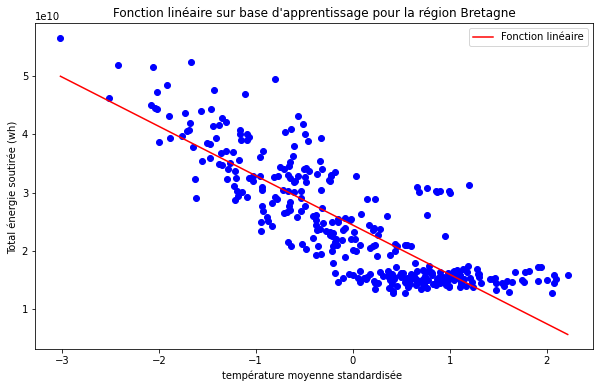

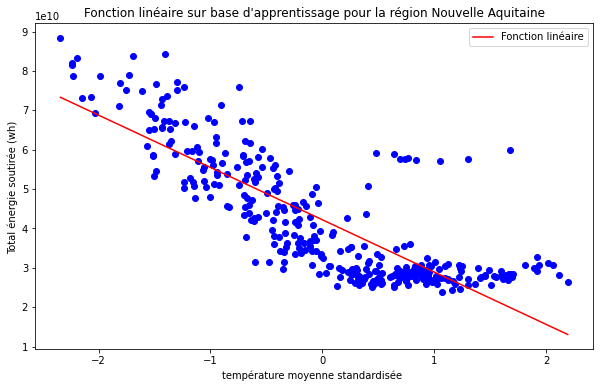

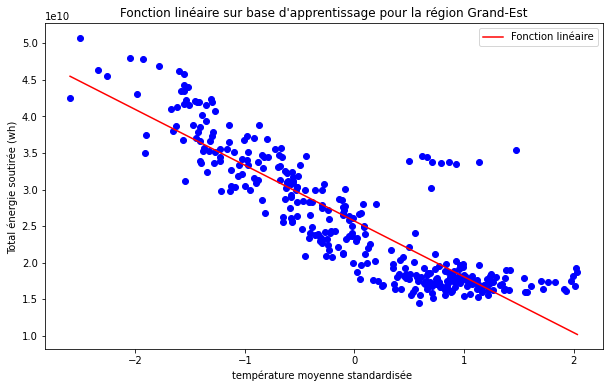

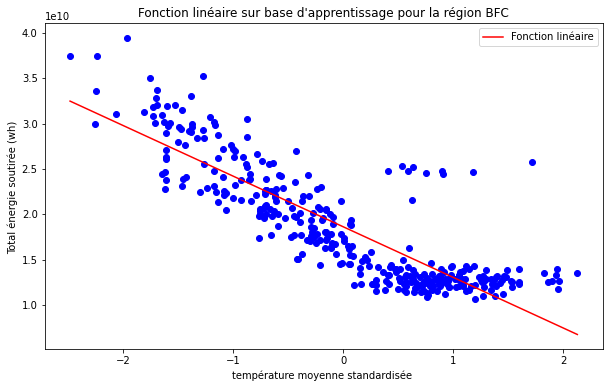

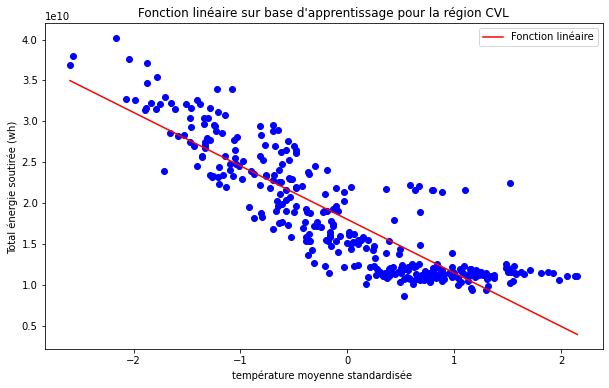

In [28]:
## affichage des résultats des régressions pour chaque régions 
plot_reg_IDF = linear_plot(X_train_IDF,Y_train_IDF,"IDF")
plot_reg_PACA = linear_plot(X_train_PACA,Y_train_PACA,"PACA")
plot_reg_ARA = linear_plot(X_train_ARA,Y_train_ARA,"ARA")
plot_reg_HDF = linear_plot(X_train_HDF,Y_train_HDF,"HDF")
plot_reg_PDL = linear_plot(X_train_PDL,Y_train_PDL,"Pays de Loire")
plot_reg_Normandie = linear_plot(X_train_Normandie,Y_train_Normandie,"Normandie")
plot_reg_Occitanie = linear_plot(X_train_Occitanie,Y_train_Occitanie,"Occitanie")
plot_reg_Bretagne = linear_plot(X_train_Bretagne,Y_train_Bretagne,"Bretagne")
plot_reg_NA = linear_plot(X_train_NA,Y_train_NA,"Nouvelle Aquitaine")
plot_reg_GE = linear_plot(X_train_GE,Y_train_GE,"Grand-Est")
plot_reg_BFC = linear_plot(X_train_BFC,Y_train_BFC,"BFC")
plot_reg_CVL = linear_plot(X_train_CVL,Y_train_CVL,"CVL")

### Régressions pour la Prévisions / Test 

In [29]:
## Création de la fonction de prévision par régression ( utilisation de sklearn meilleur pour la prévision)
def reg_sk(X_train,X_test,Y_train,Y_test):
    lm = LinearRegression() 
    lm.fit(X_train, Y_train) 
    ## On calcule le R2 de notre prédiction
    predictions = lm.predict(X_test)
    R2 = metrics.r2_score(Y_test, predictions)
    plt.scatter(Y_test, predictions)
    plt.xlabel('Total energie soutiree du Test sample')
    plt.ylabel('Total energie soutiree prédit par le modèle')
    plt.rcParams["figure.figsize"] = (10,6) 
    plt.title("Total energie soutiree du Test sample Vs Total energie soutiree prédit par le modèle")
    return R2

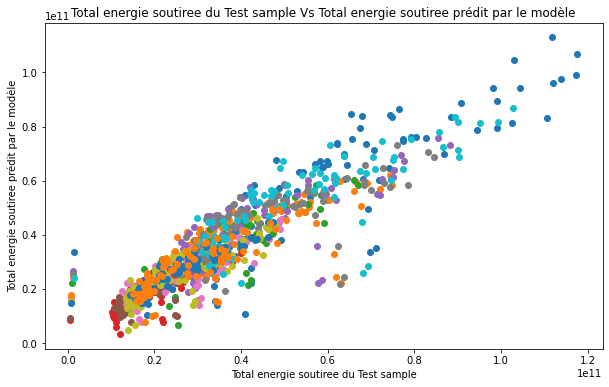

In [30]:
R2_prev_reg_IDF = reg_sk(X_train_IDF,X_test_IDF,Y_train_IDF,Y_test_IDF)
R2_prev_reg_PACA = reg_sk(X_train_PACA,X_test_PACA,Y_train_PACA,Y_test_PACA)
R2_prev_reg_HDF = reg_sk(X_train_HDF,X_test_HDF,Y_train_HDF,Y_test_HDF)
R2_prev_reg_CVL = reg_sk(X_train_CVL,X_test_CVL,Y_train_CVL,Y_test_CVL)
R2_prev_reg_NA = reg_sk(X_train_NA,X_test_NA,Y_train_NA,Y_test_NA)
R2_prev_reg_BFC = reg_sk(X_train_BFC,X_test_BFC,Y_train_BFC,Y_test_BFC)
R2_prev_reg_Bretagne = reg_sk(X_train_Bretagne,X_test_Bretagne,Y_train_Bretagne,Y_test_Bretagne)
R2_prev_reg_Occitanie = reg_sk(X_train_Occitanie,X_test_Occitanie,Y_train_Occitanie,Y_test_Occitanie)
R2_prev_reg_Normandie = reg_sk(X_train_Normandie,X_test_Normandie,Y_train_Normandie,Y_test_Normandie)
R2_prev_reg_ARA = reg_sk(X_train_ARA,X_test_ARA,Y_train_ARA,Y_test_ARA)
R2_prev_reg_GE = reg_sk(X_train_GE,X_test_GE,Y_train_GE,Y_test_GE)
R2_prev_reg_PDL = reg_sk(X_train_PDL,X_test_PDL,Y_train_PDL,Y_test_PDL)

### Classification 

Classement des R2 sur la base de test

In [31]:
liste_R2 = [R2_prev_reg_IDF,R2_prev_reg_ARA,R2_prev_reg_PACA,R2_prev_reg_CVL,R2_prev_reg_NA,R2_prev_reg_PDL,R2_prev_reg_HDF,R2_prev_reg_GE,R2_prev_reg_Bretagne,R2_prev_reg_Occitanie,R2_prev_reg_Normandie,R2_prev_reg_BFC]
liste_region = ['Île-de-France','Auvergne-Rhône-Alpes', "Provence-Alpes-Côte d'Azur",'Centre-Val de Loire','Nouvelle Aquitaine','Pays de la Loire','Hauts-de-France','Grand-Est','Bretagne','Occitanie', 'Normandie','Bourgogne-Franche-Comté']
d={'liste_region':liste_region,"R2":liste_R2}
R2_apprentissage = pd.DataFrame(d)
R2_apprentissage.sort_values("R2",ascending=False,inplace=True)
R2_apprentissage
 
 

,liste_region,R2
0,Île-de-France,0.745935
10,Normandie,0.739958
3,Centre-Val de Loire,0.736026
6,Hauts-de-France,0.725710
7,Grand-Est,0.723539
11,Bourgogne-Franche-Comté,0.708435
8,Bretagne,0.700583
5,Pays de la Loire,0.698957
1,Auvergne-Rhône-Alpes,0.680536
4,Nouvelle Aquitaine,0.621038


Classement des R2 sur la base de test 

In [32]:
liste_R2 = [R2_IDF,R2_ARA,R2_PACA,R2_CVL,R2_NA,R2_PDL,R2_HDF,R2_GE,R2_Bretagne,R2_Occitanie,R2_Normandie,R2_BFC]
liste_region = ['Île-de-France','Auvergne-Rhône-Alpes', "Provence-Alpes-Côte d'Azur",'Centre-Val de Loire','Nouvelle Aquitaine','Pays de la Loire','Hauts-de-France','Grand-Est','Bretagne','Occitanie', 'Normandie','Bourgogne-Franche-Comté']
d={'liste_region':liste_region,"R2":liste_R2}
R2_apprentissage = pd.DataFrame(d)
R2_apprentissage.sort_values("R2",ascending=False,inplace=True)
R2_apprentissage
 

,liste_region,R2
0,Île-de-France,0.776802
3,Centre-Val de Loire,0.764162
7,Grand-Est,0.763776
10,Normandie,0.747668
11,Bourgogne-Franche-Comté,0.734578
1,Auvergne-Rhône-Alpes,0.724485
6,Hauts-de-France,0.723636
5,Pays de la Loire,0.717277
8,Bretagne,0.699761
4,Nouvelle Aquitaine,0.682791


Classification par valeur de coefficients et intervalles de confiance

In [33]:
liste_coeff = [coeff_reg_IDF,coeff_reg_ARA,coeff_reg_PACA,coeff_reg_CVL,coeff_reg_NA,coeff_reg_PDL,coeff_reg_HDF,coeff_reg_GE,coeff_reg_Bretagne,coeff_reg_Occitanie,coeff_reg_Normandie,coeff_reg_BFC]
liste_region = ['Île-de-France','Auvergne-Rhône-Alpes', "Provence-Alpes-Côte d'Azur",'Centre-Val de Loire','Nouvelle Aquitaine','Pays de la Loire','Hauts-de-France','Grand-Est','Bretagne','Occitanie', 'Normandie','Bourgogne-Franche-Comté']
d={'liste_region':liste_region,"coefficient régression":liste_coeff}

coeff_apprentissage = pd.DataFrame(d)
coeff_apprentissage.sort_values("coefficient régression",ascending=False,inplace=True)
coeff_apprentissage


,liste_region,coefficient régression
11,Bourgogne-Franche-Comté,-5.576012e+09
3,Centre-Val de Loire,-6.536871e+09
7,Grand-Est,-7.627475e+09
8,Bretagne,-8.464593e+09
10,Normandie,-8.601077e+09
5,Pays de la Loire,-9.362922e+09
6,Hauts-de-France,-1.024416e+10
2,Provence-Alpes-Côte d'Azur,-1.070636e+10
9,Occitanie,-1.270643e+10
4,Nouvelle Aquitaine,-1.329112e+10


In [34]:
conf_int = pd.concat([conf_int_IDF,conf_int_ARA,conf_int_PACA,conf_int_CVL,conf_int_NA,conf_int_PDL,conf_int_HDF,conf_int_GE,conf_int_Bretagne,conf_int_Occitanie,conf_int_Normandie,conf_int_BFC])
conf_int.columns=["conf_int_down","conf_int_up"]
conf_int=conf_int.reset_index().drop(columns="index")
result_reg = coeff_apprentissage.copy()
result_reg["conf_int_down"]= conf_int["conf_int_down"]
result_reg["conf_int_up"]= conf_int["conf_int_up"]
result_reg


,liste_region,coefficient régression,conf_int_down,conf_int_up
11,Bourgogne-Franche-Comté,-5.576012e+09,-5.929907e+09,-5.222117e+09
3,Centre-Val de Loire,-6.536871e+09,-6.920299e+09,-6.153442e+09
7,Grand-Est,-7.627475e+09,-8.075355e+09,-7.179596e+09
8,Bretagne,-8.464593e+09,-9.050011e+09,-7.879175e+09
10,Normandie,-8.601077e+09,-9.128653e+09,-8.073501e+09
5,Pays de la Loire,-9.362922e+09,-9.983576e+09,-8.742268e+09
6,Hauts-de-France,-1.024416e+10,-1.091259e+10,-9.575729e+09
2,Provence-Alpes-Côte d'Azur,-1.070636e+10,-1.164015e+10,-9.772575e+09
9,Occitanie,-1.270643e+10,-1.370815e+10,-1.170472e+10
4,Nouvelle Aquitaine,-1.329112e+10,-1.424764e+10,-1.233461e+10


## II - Régression polynomial simple 
Objectif : Prédiction du Total d'énergie soutirée par journée en fonction de la température de la journée sur une région particulière 

Méthode : 
- On somme le total d'énergie soutirée par 1/2h sur une journée en agrégant tout les points de soutirages 
- On l'associe avec la température sur la journée 
- Réalisation d'une régression polynomial de degré 4 

### Recherche de la fonction polynomial pertinente 

In [38]:
## Création de la fonction de visualisation de polynome de différents degrés
def polynomial_plot(feature, label,region):
  # Create 1D array. We can use 'squeeze' function to reduce the 2D array to 1D array
  x_coordinates = np.squeeze(feature)
  y_coordinates = np.squeeze(label)
  # Contruct polynomial function
  quadratic_func2 = np.poly1d(np.polyfit(x_coordinates, y_coordinates, 2))
  quadratic_func3 = np.poly1d(np.polyfit(x_coordinates, y_coordinates, 3))
  quadratic_func4 = np.poly1d(np.polyfit(x_coordinates, y_coordinates, 4))
  quadratic_func5 = np.poly1d(np.polyfit(x_coordinates, y_coordinates, 5))
  quadratic_func6 = np.poly1d(np.polyfit(x_coordinates, y_coordinates, 6))
  # Generate evenly spaced values
  values = np.linspace(x_coordinates.min(), x_coordinates.max(), len(x_coordinates))
  plt.scatter(x_coordinates,y_coordinates, color='blue')  
  #plt.plot(values, linear_func(values), color='red', label='Fonction linéaire')
  plt.plot(values, quadratic_func2(values), color='black', label='Fonction Quadratique (degrés 2)')
  plt.plot(values, quadratic_func3(values), color='orange', label='Fonction Quadratique (degrés 3)')
  plt.plot(values, quadratic_func4(values), color='red', label='Fonction Quadratique (degrés 4)')
  plt.plot(values, quadratic_func5(values), color='cyan', label='Fonction Quadratique (degrés 5)')
  plt.plot(values, quadratic_func6(values), color='green', label='Fonction Quadratique (degrés 6)')
  plt.xlabel('température moyenne standardisée ')
  plt.ylabel('Total énergie soutirée (wh) ')
  plt.rcParams["figure.figsize"] = (10,6) # Custom figure size in inches
  plt.legend()
  plt.title("Fonction Quadratique sur base d'apprentissage pour la région "+region)
  plt.show()  

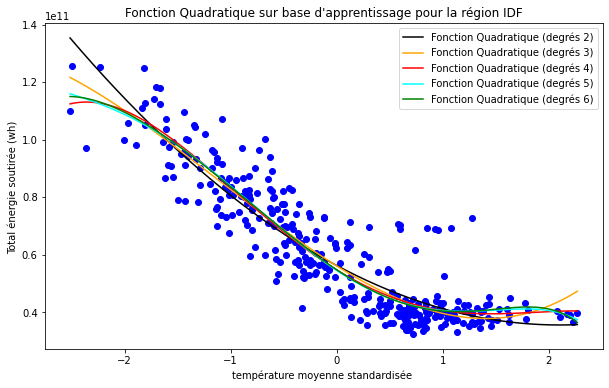

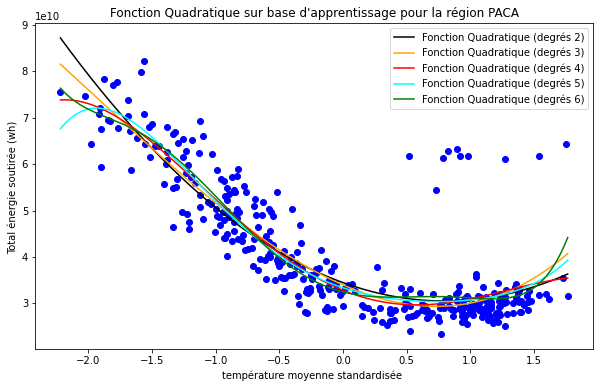

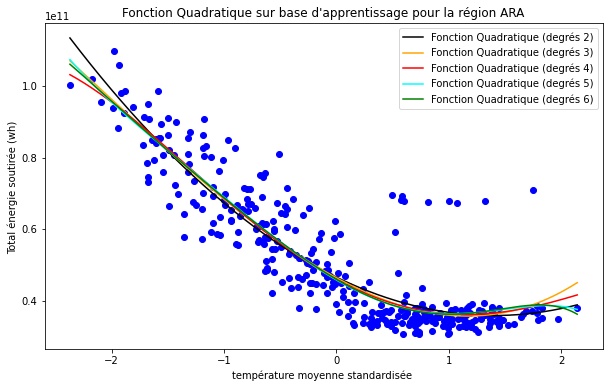

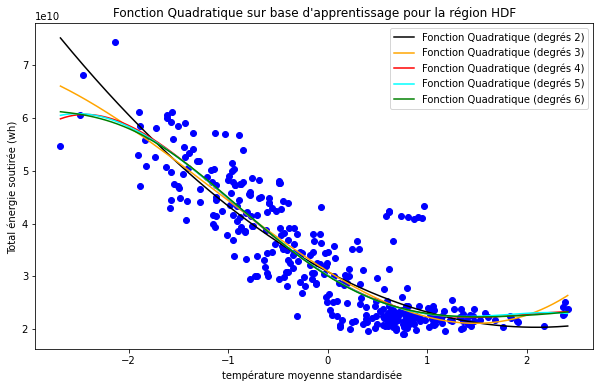

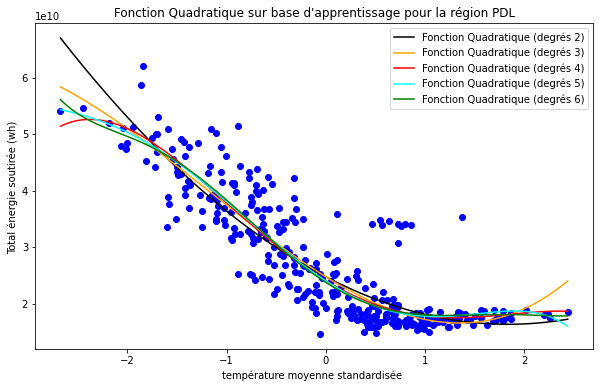

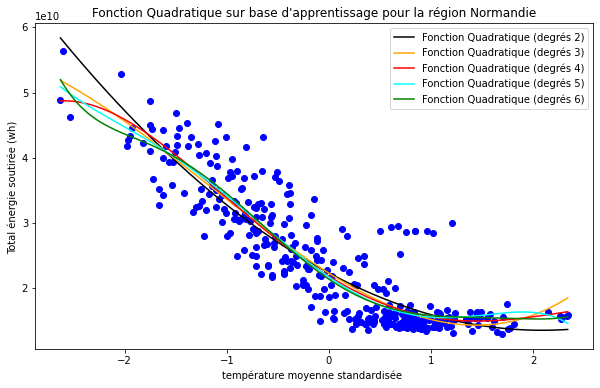

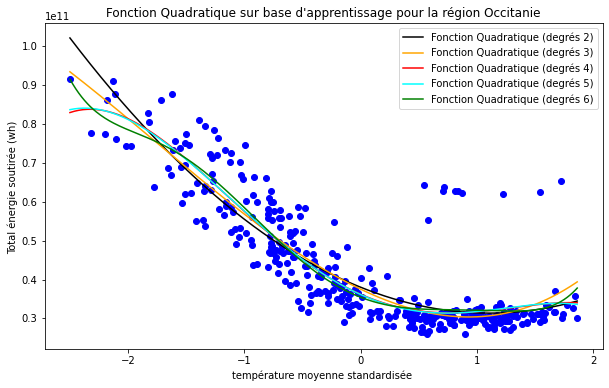

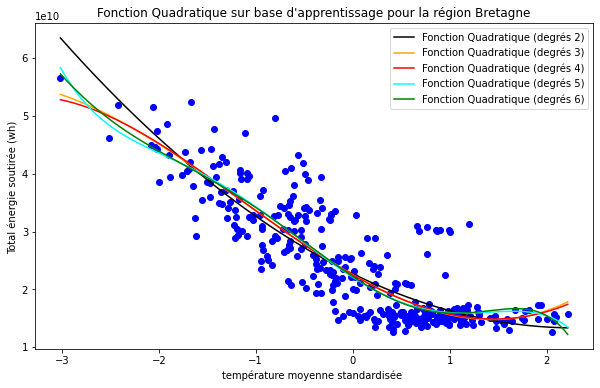

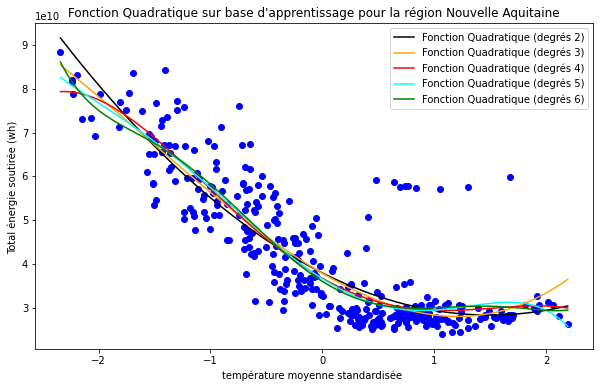

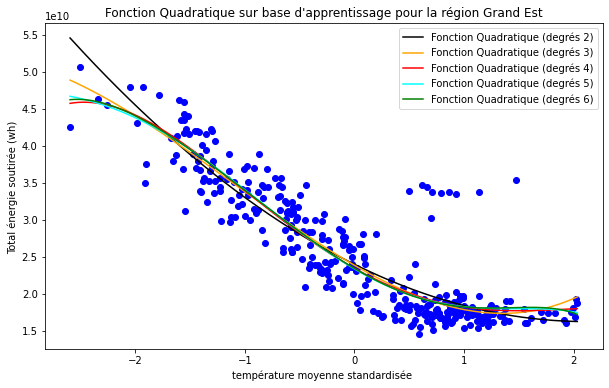

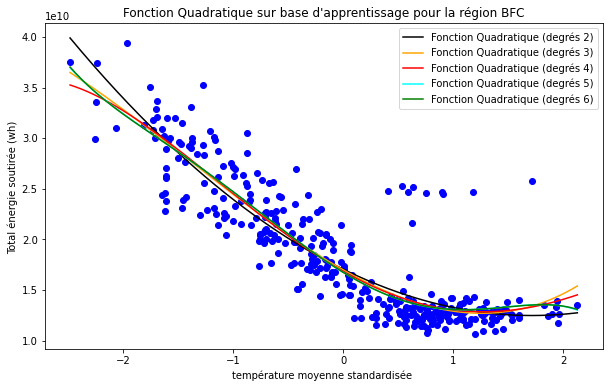

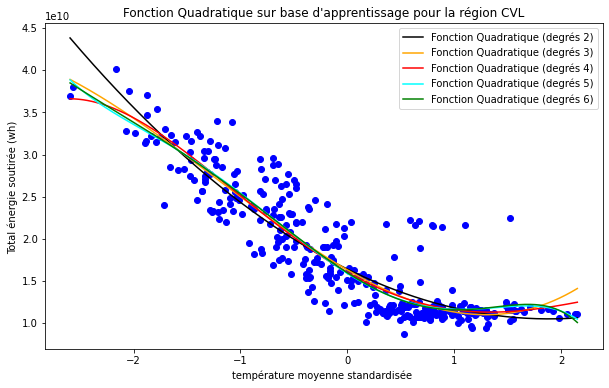

In [39]:
## affichage des résultats des régressions polynomiales pour chaque régions 
plot_poly_IDF = polynomial_plot(X_train_IDF,Y_train_IDF,"IDF")
plot_poly_PACA = polynomial_plot(X_train_PACA,Y_train_PACA,"PACA")
plot_poly_ARA = polynomial_plot(X_train_ARA,Y_train_ARA,"ARA")
plot_poly_HDF = polynomial_plot(X_train_HDF,Y_train_HDF,"HDF")
plot_poly_PDL = polynomial_plot(X_train_PDL,Y_train_PDL,"PDL")
plot_poly_Normandie = polynomial_plot(X_train_Normandie,Y_train_Normandie,"Normandie")
plot_poly_Occitanie = polynomial_plot(X_train_Occitanie,Y_train_Occitanie,"Occitanie")
plot_poly_Bretagne = polynomial_plot(X_train_Bretagne,Y_train_Bretagne,"Bretagne")
plot_poly_NA = polynomial_plot(X_train_NA,Y_train_NA,'Nouvelle Aquitaine')
plot_poly_GE = polynomial_plot(X_train_GE,Y_train_GE,"Grand Est")
plot_poly_BFC = polynomial_plot(X_train_BFC,Y_train_BFC,"BFC")
plot_poly_CVL = polynomial_plot(X_train_CVL,Y_train_CVL,"CVL")

### Partie Apprentissage 

In [40]:
## Création de la fonction de régression polynomial
def reg_sm_poly(X_train,Y_train):
    poly = PolynomialFeatures(degree = 4) 
    X_poly = poly.fit_transform(X_train) 
    poly.fit(X_poly,Y_train) 
    X_poly_sm = sm.add_constant(X_poly)
    model = sm.OLS(Y_train,X_poly_sm).fit()
    print_model = model.summary()
    return print_model,model.rsquared


In [41]:
## Stockage des résultats des régressions pour chaque régions 
res_poly_IDF, R2_poly_IDF = reg_sm_poly(X_train_IDF,Y_train_IDF)
res_poly_PACA,R2_poly_PACA = reg_sm_poly(X_train_PACA,Y_train_PACA)
res_poly_ARA,R2_poly_ARA = reg_sm_poly(X_train_ARA,Y_train_ARA)
res_poly_HDF,R2_poly_HDF = reg_sm_poly(X_train_HDF,Y_train_HDF)
res_poly_PDL,R2_poly_PDL = reg_sm_poly(X_train_PDL,Y_train_PDL)
res_poly_Normandie,R2_poly_Normandie = reg_sm_poly(X_train_Normandie,Y_train_Normandie)
res_poly_Occitanie,R2_poly_Occitanie = reg_sm_poly(X_train_Occitanie,Y_train_Occitanie)
res_poly_Bretagne,R2_poly_Bretagne = reg_sm_poly(X_train_Bretagne,Y_train_Bretagne)
res_poly_NA,R2_poly_NA = reg_sm_poly(X_train_NA,Y_train_NA)
res_poly_GE,R2_poly_GE = reg_sm_poly(X_train_GE,Y_train_GE)
res_poly_BFC, R2_poly_BFC= reg_sm_poly(X_train_BFC,Y_train_BFC)
res_poly_CVL, R2_poly_CVL = reg_sm_poly(X_train_CVL,Y_train_CVL)

### Partie Test/prédictions 

In [42]:
def reg_sk_poly(X_train,X_test,Y_train,Y_test):
    poly = PolynomialFeatures(degree = 4)
    X_poly = poly.fit_transform(X_train) 
    lm = LinearRegression() 
    lm.fit(X_poly, Y_train) 
    predictions = lm.predict(poly.fit_transform(X_test))
    R2 = metrics.r2_score(Y_test, predictions)
    plt.scatter(Y_test, predictions)
    plt.xlabel('Total energie soutiree du Test sample')
    plt.ylabel('Total energie soutiree prédit par le modèle')
    plt.rcParams["figure.figsize"] = (10,6) 
    plt.title("Total energie soutiree du Test sample Vs Total energie soutiree prédit par le modèle")
    return R2


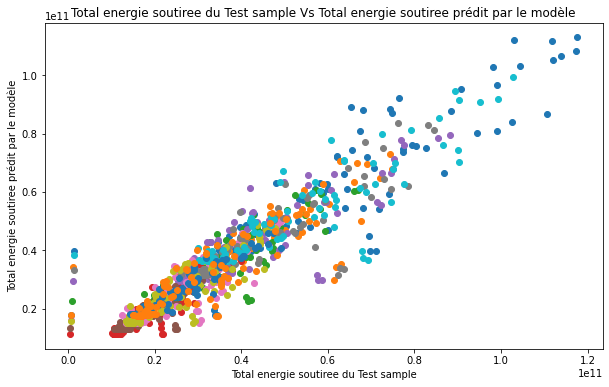

In [84]:
R2_prev_poly_IDF = reg_sk_poly(X_train_IDF,X_test_IDF,Y_train_IDF,Y_test_IDF)
R2_prev_poly_PACA = reg_sk_poly(X_train_PACA,X_test_PACA,Y_train_PACA,Y_test_PACA)
R2_prev_poly_HDF = reg_sk_poly(X_train_HDF,X_test_HDF,Y_train_HDF,Y_test_HDF)
R2_prev_poly_CVL = reg_sk_poly(X_train_CVL,X_test_CVL,Y_train_CVL,Y_test_CVL)
R2_prev_poly_NA = reg_sk_poly(X_train_NA,X_test_NA,Y_train_NA,Y_test_NA)
R2_prev_poly_BFC = reg_sk_poly(X_train_BFC,X_test_BFC,Y_train_BFC,Y_test_BFC)
R2_prev_poly_Bretagne = reg_sk_poly(X_train_Bretagne,X_test_Bretagne,Y_train_Bretagne,Y_test_Bretagne)
R2_prev_poly_Occitanie = reg_sk_poly(X_train_Occitanie,X_test_Occitanie,Y_train_Occitanie,Y_test_Occitanie)
R2_prev_poly_Normandie = reg_sk_poly(X_train_Normandie,X_test_Normandie,Y_train_Normandie,Y_test_Normandie)
R2_prev_poly_ARA = reg_sk_poly(X_train_ARA,X_test_ARA,Y_train_ARA,Y_test_ARA)
R2_prev_poly_GE = reg_sk_poly(X_train_GE,X_test_GE,Y_train_GE,Y_test_GE)
R2_prev_poly_PDL = reg_sk_poly(X_train_PDL,X_test_PDL,Y_train_PDL,Y_test_PDL)


### Classification 

Classification des R2 sur la base d'apprentissage 

In [85]:
liste_R2 = [R2_poly_IDF,R2_poly_ARA,R2_poly_PACA,R2_poly_CVL,R2_poly_NA,R2_poly_PDL,R2_poly_HDF,R2_poly_GE,R2_poly_Bretagne,R2_poly_Occitanie,R2_poly_Normandie,R2_poly_BFC]
liste_region = ['Île-de-France','Auvergne-Rhône-Alpes', "Provence-Alpes-Côte d'Azur",'Centre-Val de Loire','Nouvelle Aquitaine','Pays de la Loire','Hauts-de-France','Grand-Est','Bretagne','Occitanie', 'Normandie','Bourgogne-Franche-Comté']
d={'liste_region':liste_region,"R2":liste_R2}
R2_apprentissage = pd.DataFrame(d)
R2_apprentissage.sort_values("R2",ascending=False,inplace=True)
R2_apprentissage

,liste_region,R2
0,Île-de-France,0.844232
3,Centre-Val de Loire,0.834143
7,Grand-Est,0.819936
10,Normandie,0.817584
1,Auvergne-Rhône-Alpes,0.815004
11,Bourgogne-Franche-Comté,0.803732
5,Pays de la Loire,0.802804
6,Hauts-de-France,0.795245
4,Nouvelle Aquitaine,0.784361
9,Occitanie,0.782392


Classification des R2 sur la base de test 

In [86]:
liste_R2 = [R2_prev_poly_IDF,R2_prev_poly_ARA,R2_prev_poly_PACA,R2_prev_poly_CVL,R2_prev_poly_NA,R2_prev_poly_PDL,R2_prev_poly_HDF,R2_prev_poly_GE,R2_prev_poly_Bretagne,R2_prev_poly_Occitanie,R2_prev_poly_Normandie,R2_prev_poly_BFC]
liste_region = ['Île-de-France','Auvergne-Rhône-Alpes', "Provence-Alpes-Côte d'Azur",'Centre-Val de Loire','Nouvelle Aquitaine','Pays de la Loire','Hauts-de-France','Grand-Est','Bretagne','Occitanie', 'Normandie','Bourgogne-Franche-Comté']
d={'liste_region':liste_region,"R2":liste_R2}
R2_apprentissage = pd.DataFrame(d)
R2_apprentissage.sort_values("R2",ascending=False,inplace=True)
R2_apprentissage

,liste_region,R2
0,Île-de-France,0.801655
3,Centre-Val de Loire,0.790282
7,Grand-Est,0.781724
11,Bourgogne-Franche-Comté,0.778733
6,Hauts-de-France,0.774283
10,Normandie,0.769971
1,Auvergne-Rhône-Alpes,0.763318
5,Pays de la Loire,0.750445
4,Nouvelle Aquitaine,0.730004
8,Bretagne,0.726088


## Regression linéaire par morceaux 

In [101]:
## Création des indicatrices
Y = enedis_IDF["total_energie_soutiree_wh"].to_numpy()
X = enedis_IDF["tmoy_scaled"].to_numpy()



In [102]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
X_train_affiche=X_train
X_test_affiche = X_test

In [103]:
to=0.13
## Indicatrice pour Train
indicsupto_train= [ele if ele>to else 0 for ele in X_train]
indicinfto_train= [ele if ele<=to else 0 for ele in X_train]

## Indicatrice pour Test
indicsupto_test= [ele if ele>to else 0 for ele in X_test]
indicinfto_test= [ele if ele<=to else 0 for ele in X_test]


In [104]:
##  Transformation en df pour l'échantillon train
df_x1_train = pd.DataFrame(indicinfto_train, columns = ['Indicatrice < 15 moy'])
df_x2_train = pd.DataFrame(indicsupto_train, columns = ['Indicatrice >= 15 moy'])

X_train = pd.DataFrame(np.c_[df_x1_train["Indicatrice < 15 moy"],df_x2_train["Indicatrice >= 15 moy"]],columns = ["Indicatrice < 15 moy","Indicatrice >= 15 moy"])



In [105]:
##  Transformation en df pour l'échantillon test
df_x1_test = pd.DataFrame(indicinfto_test, columns = ['Indicatrice < 15 moy'])
df_x2_test = pd.DataFrame(indicsupto_test, columns = ['Indicatrice >= 15 moy'])

X_test = pd.DataFrame(np.c_[df_x1_test["Indicatrice < 15 moy"],df_x2_test["Indicatrice >= 15 moy"]],columns = ["Indicatrice < 15 moy","Indicatrice >= 15 moy"])


### Partie Apprentissage 

In [114]:
X_train_sm = sm.add_constant(X_train)
model = sm.OLS(Y_train,X_train).fit()
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.792
Model:                            OLS   Adj. R-squared (uncentered):              0.791
Method:                 Least Squares   F-statistic:                              661.9
Date:                Thu, 16 Feb 2023   Prob (F-statistic):                   3.69e-119
Time:                        17:08:29   Log-Likelihood:                         -8908.9
No. Observations:                 349   AIC:                                  1.782e+04
Df Residuals:                     347   BIC:                                  1.783e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [115]:
lm = LinearRegression(fit_intercept=True) 
lm.fit(X_train, Y_train) 

LinearRegression()

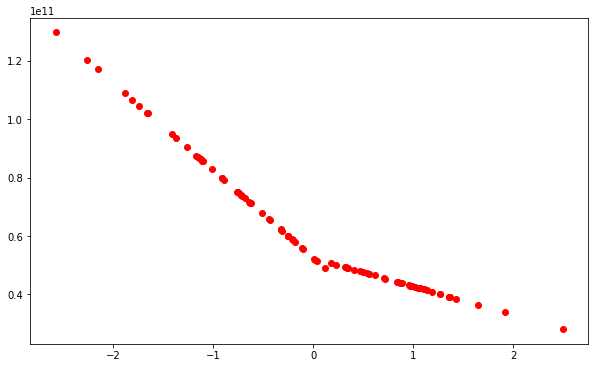

In [116]:
Y_predicted = lm.predict(X_test)


plt.scatter(X_test_affiche,Y_predicted,color = "red" )
#plt.scatter(X_train_affiche,Y_train) 


Pente :  [-2.99733665e+10 -9.73901349e+09]
Ordonnée à l'origine :  52464805111.82976
Racine carrée de l'erreur quadratique moyenne :  1.2784499262495911e+20
Sccore R2 :  0.7838208690206065


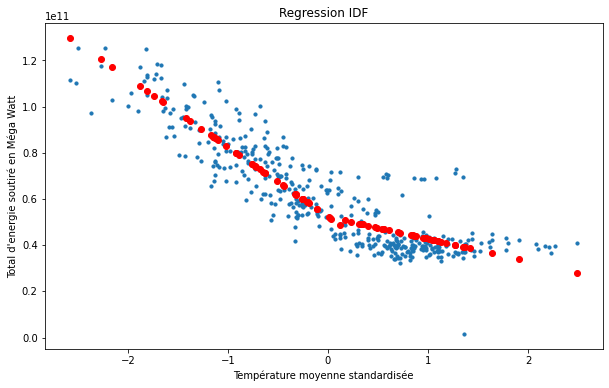

In [118]:
Y_predicted = lm.predict(X_test)

# Évaluation du modèle
rmse = mean_squared_error(Y_test, Y_predicted)
r2 = r2_score(Y_test, Y_predicted)
# Affichage des valeurs
print("Pente : " ,lm.coef_)
print("Ordonnée à l'origine : ", lm.intercept_)
print("Racine carrée de l'erreur quadratique moyenne : ", rmse)
print('Sccore R2 : ', r2)
# Tracée des valeurs
# Points de données
plt.scatter(enedis_IDF["tmoy_scaled"], Y, s=10)
plt.xlabel('Température moyenne standardisée')
plt.ylabel("Total d'energie soutiré en Méga Watt")
plt.title("Regression IDF")
# Valeurs prédites
plt.scatter(X_test_affiche, Y_predicted, color='r')
plt.show()

## Régression linéaire ( par arbre de décisions )

In [75]:
X = enedis_IDF[["tmoy_scaled"]].to_numpy()
Y = enedis_IDF[["total_energie_soutiree_wh"]].to_numpy()

model = DecisionTreeRegressor(random_state=0, max_depth=2)
model.fit(X,Y)

Y_predicted = model.predict(X)


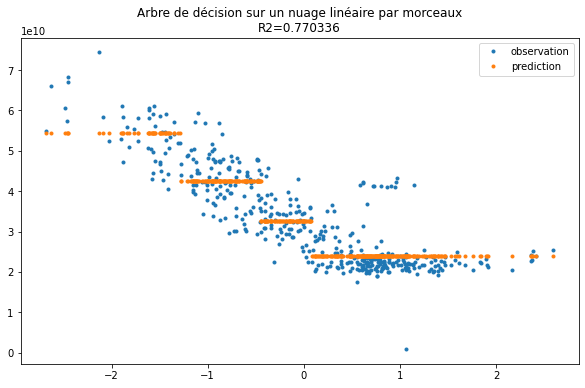

In [76]:
fig, ax = plt.subplots(1, 1)
ax.plot(X, Y , ".", label="observation")
ax.plot(X, Y_predicted, ".", label="prediction")
ax.legend()
r2 = r2_score(Y, model.predict(X))
ax.set_title("Arbre de décision sur un nuage linéaire par morceaux\nR2=%f" % r2);

In [78]:
## On trie les seuils
th = list(sorted(set(model.tree_.threshold)))
th += [(th[i] + th[i-1])/2 for i in range(1,len(th))]
th = list(sorted(th))
th

0.08163629099726677

In [140]:
W = np.zeros((x.shape[0], len(th)+1))
X= x[:, 0]
W[:, 0] = X
for i in range(len(th)):
    W[X > th[i], i+1] = X[X > th[i]]

In [141]:
model = sm.OLS(Y,W)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.891
Model:                            OLS   Adj. R-squared (uncentered):              0.889
Method:                 Least Squares   F-statistic:                              436.9
Date:                Thu, 09 Feb 2023   Prob (F-statistic):                   7.43e-201
Time:                        23:24:59   Log-Likelihood:                         -11018.
No. Observations:                 437   AIC:                                  2.205e+04
Df Residuals:                     429   BIC:                                  2.208e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -3.558e+10    3.5e+09    -10.172      0.000   -4.25e+10   -2.87e+10
x2          3.535e+10   8.08e+09      4.378      0.000    1.95e+10    5.12e+10
x3          2.852e+10   7.36e+09      3.873      0.000     1.4e+10     4.3e+10
x4         -1.547e+10   1.22e+09    -12.712      0.000   -1.79e+10   -1.31e+10
x5         -5.099e+09    5.6e+08     -9.098      0.000    -6.2e+09      -4e+09
x6         -2.642e+09   3.96e+08     -6.677      0.000   -3.42e+09   -1.86e+09
x7          -9.39e+08   3.99e+08     -2.352      0.019   -1.72e+09   -1.54e+08
x8         -2.072e+09   2.94e+08     -7.053      0.000   -2.65e+09   -1.49e+09
==============================================================================
Omnibus:                      275.976   Durbin-Watson:                   1.213
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2617.067
Skew:                           2.640   Prob(JB):                         0.00
Kurtosis:                      13.764   Cond. No.                         423.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

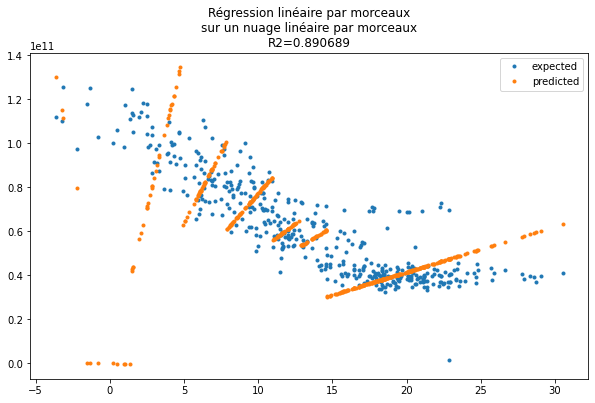

In [143]:
Y_predicted = results.predict(W)
fig, ax = plt.subplots(1, 1)
ax.plot(x[:, 0], Y, ".", label="expected")
ax.plot(x[:, 0], Y_predicted, ".", label="predicted")
ax.legend()
ax.set_title("Régression linéaire par morceaux\nsur un nuage linéaire par morceaux\nR2=%f" % results.rsquared);